# Model development

This code is specically desgined to model the data and make predictions

## Libraries import

In [26]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import lightgbm as lgb

## Global variables

In [2]:
TOTAL_DATAFRAME = 'total_dataframe.csv'

## Execution

### 1. Read files

In [3]:
df_total_dataframe = pl.read_csv(TOTAL_DATAFRAME, separator=";")

### 2. Data preview

In [5]:
df_total_dataframe.head(10)

ReportID,SupplierName,Date,GarmentType,Material,ProductReference,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,PackagingQuality,IncidentID,IssueDescription,ResolutionStatus,CostImpact,ProductName,Size,Collection,Weight
i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,f64
1,"""SupplierB""","""2023-09-27""","""Dress""","""Cotton""","""DRE-COT-1992""",7,"""Method1""","""LayoutA""","""Good""",null,null,null,null,null,null,null,null
2,"""SupplierB""","""2024-05-30""","""Coat""","""Polyester""","""COA-POL-8528""",12,"""Method2""","""LayoutB""","""Bad""",null,null,null,null,null,null,null,null
3,"""SupplierC""","""2023-07-25""","""Sweater""","""Wool""","""SWE-WOO-2045""",14,"""Method1""","""LayoutD""","""Bad""",null,null,null,null,null,null,null,null
4,"""SupplierC""","""2023-06-16""","""Dress""","""Polyester""","""DRE-POL-3008""",17,"""Method1""","""LayoutE""","""Good""",null,null,null,null,null,null,null,null
5,"""SupplierA""","""2024-06-07""","""Shirt""","""Polyester""","""SHI-POL-5449""",20,"""Method2""","""LayoutB""","""Good""",null,null,null,null,null,null,null,null
6,"""SupplierA""","""2023-04-28""","""Jacket""","""Polyester""","""JAC-POL-4551""",5,"""Method1""","""LayoutE""","""Bad""",null,null,null,null,null,null,null,null
7,"""SupplierB""","""2023-08-11""","""Skirt""","""Wool""","""SKI-WOO-6663""",null,"""Method1""","""LayoutC""","""Good""",null,null,null,null,null,null,null,null
8,"""SupplierC""","""2023-07-06""","""Jacket""","""Polyester""","""JAC-POL-3243""",12,"""Method2""","""LayoutD""","""Good""",null,null,null,null,null,null,null,null
9,"""SupplierB""","""2024-03-12""","""Suit""","""Cotton""","""SUI-COT-3333""",17,"""Method3""","""LayoutB""","""Good""",null,null,null,null,null,null,null,null


### 3. Filter only useful values

In [6]:
df_filtered = df_total_dataframe.filter(
    (pl.col("ProposedUnitsPerCarton").is_not_null()) &
    (pl.col("ProductName").is_not_null()) &
    (pl.col("ProposedFoldingMethod").is_not_null()) &
    (pl.col("ProposedLayout").is_not_null()) &
    (pl.col("PackagingQuality").is_not_null())
)

## Model

### 1. Convert to pandas

In [27]:
df_model = df_filtered.to_pandas()

### 2. Drop unused columns

In [28]:
df_model = df_model.drop(columns=[
    "ReportID", "ProductReference", "IncidentID", "ProductName"
])

### 3. Convert Date to datetime + extract features

In [29]:
df_model["Date"] = pd.to_datetime(df_model["Date"])

# Extract components
df_model["Year"] = df_model["Date"].dt.year
df_model["Month"] = df_model["Date"].dt.month
df_model["Day"] = df_model["Date"].dt.day
df_model["Weekday"] = df_model["Date"].dt.weekday

# Drop original date
df_model = df_model.drop(columns=["Date"])

### 4. Encode categorical columns

In [30]:
cat_cols = df_model.select_dtypes(include="object").columns.tolist()
for col in cat_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

### 5. Define target and features

In [31]:
X = df_model.drop(columns=["PackagingQuality"])
y = df_model["PackagingQuality"]

In [32]:
y = LabelEncoder().fit_transform(y)

### 6. Train/test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### 7. Train LightGBM model

In [40]:
model = lgb.LGBMClassifier(
    objective="binary",           # For binary classification
    metric="binary_logloss",      # Use logloss or "auc"
    boosting_type="gbdt",         # Gradient Boosted Decision Trees
    num_leaves=5,                 # Controls complexity (higher = more complex)
    max_depth=5,                  # Let it grow naturally
    learning_rate=0.05,           # Smaller = slower, but often better
    n_estimators=500,             # Number of trees
    subsample=0.8,                # Randomly sample data per tree
    colsample_bytree=0.8,         # Randomly sample features per tree
    random_state=42
)

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4916, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 7164, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686209 -> initscore=0.782454
[LightGBM] [Info] Start training from score 0.782454


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=5,
               metric='binary_logloss', n_estimators=500, num_leaves=5,
               objective='binary', random_state=42, subsample=0.8)

### 8. Evaluate the model

In [41]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.09      0.16      1040
           1       0.67      0.95      0.79      2031

    accuracy                           0.66      3071
   macro avg       0.59      0.52      0.47      3071
weighted avg       0.61      0.66      0.57      3071



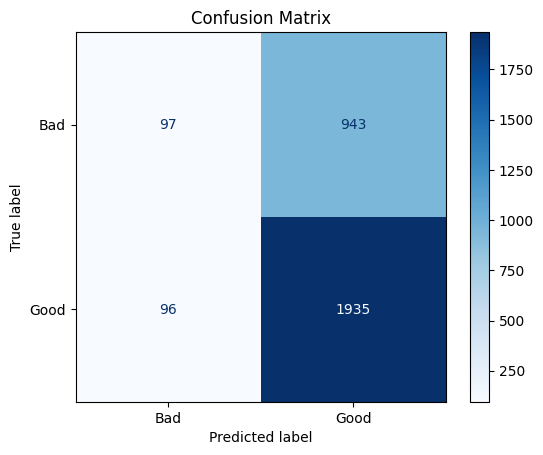

In [42]:
# Predict
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good"])

# Plot it
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [43]:
y_prob = model.predict_proba(X_test)[:, 1]
print("AUC Score:", roc_auc_score(y_test, y_prob))

AUC Score: 0.6422158466840888


### 9. Feature importance

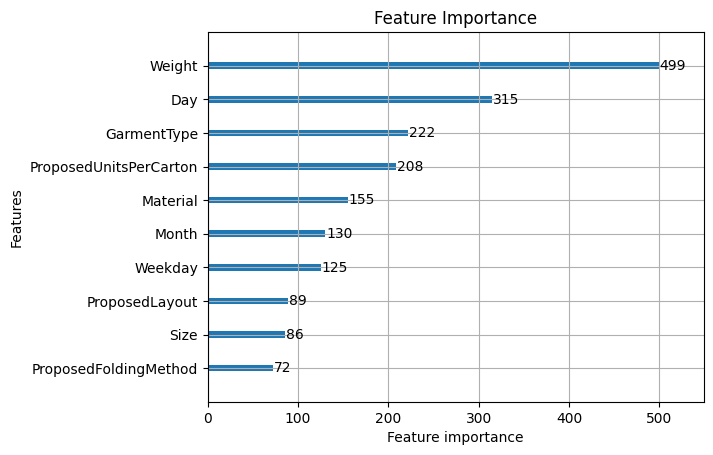

In [38]:
lgb.plot_importance(model, max_num_features=10)
plt.title("Feature Importance")
plt.show()